In [1]:
%matplotlib notebook
from astropy.io import fits
from astropy.table import Table
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#image_path = '/home/aalvarez/Work/Data/sim07/sim07.fits'
psf_path = '/home/aalvarez/Work/Data/sim08/sex.out.psf'
psf_snapshot_path = '/home/aalvarez/Work/Data/sim08/snap_sex.out.fits'

In [3]:
class PsfEx(object):
    def __init__(self, path):
        psfex_fits = fits.open(path)
        if 'PSF_DATA' not in psfex_fits:
            raise Exception('Missing PSF_DATA')
        self._from_hdu(psfex_fits['PSF_DATA'])
        
    def _from_hdu(self, psf_data):
        self._n_axis = psf_data.header['POLNAXIS']
        self._groups = list()
        self._names = list()
        self._offsets = list()
        self._scales = list()
        
        for i in range(1, self._n_axis + 1):
            self._groups.append(psf_data.header[f'POLGRP{i}'] - 1)
            self._names.append(psf_data.header[f'POLNAME{i}'])
            self._offsets.append(psf_data.header[f'POLZERO{i}'])
            self._scales.append(psf_data.header[f'POLSCAL{i}'])
            
        self._n_groups = psf_data.header['POLNGRP']
        self._degrees = list()
        for i in range(1, self._n_groups + 1):
            self._degrees.append(psf_data.header[f'POLDEG{i}'])
            
        self._width = psf_data.header['PSFAXIS1']
        self._height = psf_data.header['PSFAXIS2']
        self._n_coefs = psf_data.header['PSFAXIS3']
        
        if self._n_coefs > 1:
            self._powers = self._calculate_powers()
        
        self._coefs = np.array(psf_data.data[0][0], copy=True, dtype=np.float64)
            
    def _calculate_powers(self):
        exponents = np.zeros(self._n_axis, dtype=np.int)
        powers = np.zeros((self._n_coefs, self._n_axis), dtype=np.int)
        group_exponents = np.zeros(self._n_groups, dtype=np.int)
        group_exponents[:self._n_groups] = self._degrees
        
        # Constant
        powers[0,:] = 0
        if self._n_axis:
            group_exponents[self._groups[0]] -= 1
        
        # Polynom
        exponents[0] = 1
        pi = 1
        for t in reversed(range(1, self._n_coefs)):
            powers[pi,:] = exponents[:]
            pi += 1
            
            ei = 0
            for group in self._groups:
                if group_exponents[group]:
                    group_exponents[group] -= 1
                    exponents[ei] += 1
                    break
                else:
                    group_exponents[group] = exponents[ei]
                    exponents[ei] = 0
                    ei += 1
        
        return powers
    
    def get_size(self):
        return self._width, self._height
    
    def normalize_properties(self, *args):
        out = list()
        for i, a in enumerate(args):
            out.append((a - self._offsets[i]) / self._scales[i])
        return out
    
    def get_repr(self, i):
        if i == 0:
            return 'Constant'
        
        components = []
        for v, p in zip(self._names, self._powers[i,:]):
            if p != 0:
                components.append(f'{v}$^{p}$')
            
        return ' + '.join(components)
    
    def get_psf_scaled(self, *args):
        result = np.array(self._coefs[0], copy=True)
        for i in range(1, self._n_coefs):
            exp = self._powers[i,:]
            coefs = self._coefs[i]
            acc = 1
            for v, e in zip(args, exp):
                acc *= v ** e
            result += coefs * acc
        return result
    
    def get_psf(self, *args):
        properties = self.normalize_properties(*args)
        return self.get_psf_scaled(*properties)

In [4]:
psfex = PsfEx(psf_path)

<IPython.core.display.Javascript object>


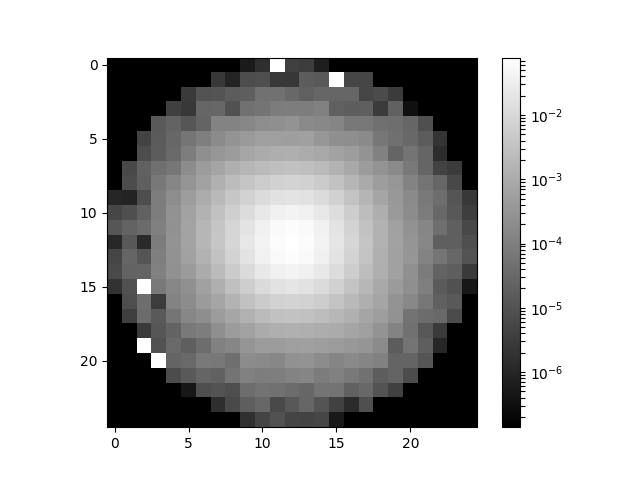

In [5]:
test_psf = psfex.get_psf_scaled(0., 0.)
plt.figure()
plt.imshow(
    test_psf,
    cmap = plt.get_cmap('binary_r'),
    norm = colors.LogNorm()
)
plt.colorbar()

### Let's try to compare with the snapshot generated by psfex

In [6]:
snap = fits.open(psf_snapshot_path)
psf_size = psfex.get_size()[0]
snap_nrows = int(snap[0].data.shape[0] / psf_size)
snap_ncols = int(snap[0].data.shape[1] / psf_size)
nsteps = snap_nrows * snap_ncols
ndims = 1 if snap_nrows == 1 else 2
steps_per_dim = max(snap_nrows, snap_ncols)
step = 1./steps_per_dim
print(snap_ncols, snap_nrows)

9 9


In [7]:
def get_psf_from_snapshot(snap, size, x, y):
    coords = -(1.-step)/2 + x * step, -(1.-step)/2 + y * step
    return np.array(coords), snap[0].data[y*size:(y+1)*size:,x*size:(x+1)*size]

<IPython.core.display.Javascript object>


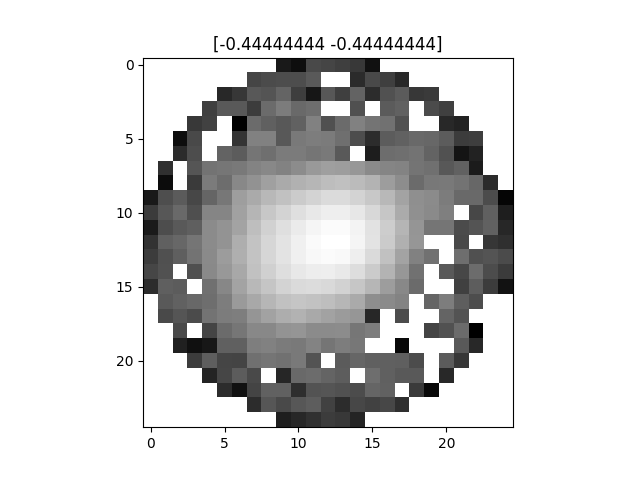

Text(0.5,1,'[-0.44444444 -0.44444444]')

In [8]:
coords, snap_psf = get_psf_from_snapshot(snap, psf_size, 0, 0)
plt.figure()
plt.imshow(
    snap_psf,
    cmap = plt.get_cmap('binary_r'),
    norm = colors.LogNorm()
)
plt.title('{}'.format(coords))

<IPython.core.display.Javascript object>


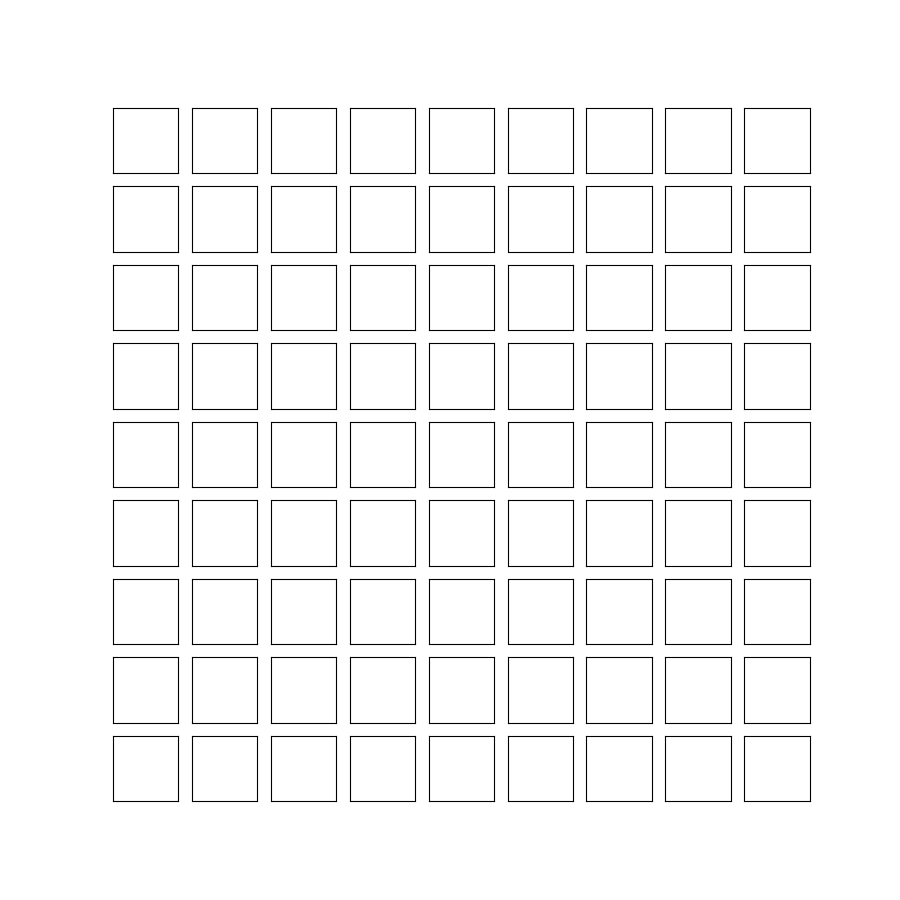

In [9]:
fig, axs = plt.subplots(snap_nrows, snap_ncols, figsize=(9,9))
close_cmap = plt.get_cmap('binary_r')

ims = []

for i in range(snap_nrows):
    for j in range(snap_ncols):
        coords, snap_psf = get_psf_from_snapshot(snap, psf_size, j, i)
        reconstructed = psfex.get_psf_scaled(*coords)
        im = axs[i, j].imshow(
            np.array(np.isclose(snap_psf, reconstructed), dtype=np.int),
            cmap=close_cmap,
            norm=colors.Normalize(vmin=0, vmax=1)
        )
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        ims.append(im)
